# Implémentation de méthodes élémentaires pour la classification supervisée : ADL, ADQ, Naive Bayes et classifieur par plus proches voisins

Pour ce TP, nous aurons besoin des modules Python ci-dessous, il vous faut donc évidemment exécuter cette première cellule.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.covariance import empirical_covariance
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KDTree

Le jeu de données [Vertebral Column](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column) permet d'étudier les pathologies d'hernie discale et de Spondylolisthesis. Ces deux pathologies sont regroupées dans le jeu de données en une seule catégorie dite `Abnormale`. 

Il s'agit donc d'un problème de classification supervisée à deux classes :
- Normale (NO) 
- Abnormale (AB)    

avec 6 variables bio-mécaniques disponibles (features).

L'objectif du TP est d'implémenter quelques méthodes simples de classification supervisée pour ce problème.

# Importation des données

> Télécharger le fichier column_2C.dat depuis le site de l'UCI à [cette adresse](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column). 
>
> On peut importer les données sous python par exemple avec la librairie [pandas](https://pandas.pydata.org/pandas-docs/stable/10min.html). Vous pourrez au besoin consulter la documentation de la fonction [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). 
> 
> Le chemin donné dans la fonction `read_csv`est une chaîne de caractère qui spécifie le chemin complet vers le ficher sur votre machine. On peut aussi donner une adresse url si le fichier est disponible en ligne.
>
> Attention à la syntaxe pour les chemins sous Windows doit etre de la forme  `C:/truc/machin.csv`. 
> 
> Voir ce [blog](https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f) pour en savoir plus sur la "manipulation des chemins" sur des OS variés. 

In [2]:
file_path= 'column_2C.dat'

vertebral = pd.read_csv(file_path,
                          delim_whitespace= '\t')

vertebral.columns = ["pelvic_incidence",
                                       "pelvic_tilt",
                                       "lumbar_lordosis_angle",
                                       "sacral_slope",
                                       "pelvic_radius",
                                       "degree_spondylolisthesis",
                                       "class"]

> Vérifier à l'aide des méthodes `.head()`  et `describe()` que les données sont bien importées.

In [3]:
vertebral.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,39.06,10.06,25.02,29.00,114.41,4.56,AB
1,68.83,22.22,50.09,46.61,105.99,-3.53,AB
2,69.30,24.65,44.31,44.64,101.87,11.21,AB
3,49.71,9.65,28.32,40.06,108.17,7.92,AB
4,40.25,13.92,25.12,26.33,130.33,2.23,AB


In [4]:
np.shape(vertebral)

(309, 7)

In [5]:
vertebral.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,60.488285,17.526699,51.970583,42.961877,117.982848,26.382654
std,17.263462,10.020300,18.570553,13.443779,13.293909,37.589284
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.430000,10.660000,37.000000,33.340000,110.710000,1.630000
50%,58.600000,16.300000,49.780000,42.440000,118.340000,12.070000
75%,72.960000,21.940000,63.000000,52.740000,125.480000,41.420000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


> Les librairies de Machine Learning telles que `sckitlearn` prennent en entrée des tableau numpy (pas des objets pandas). Créer un tableau numpy que vous nommerez `VertebralVar` pour les features et un vecteur numpy `VertebralClas` pour la variable de classe. Voir par exemple [ici](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html#pandas.DataFrame.to_numpy).

In [6]:
vertebral_without_class = (vertebral.iloc[:,:6])
vertebral_class = (vertebral.iloc[:,6])
vertebralVar  = vertebral_without_class.to_numpy()
vertebralClas = vertebral_class.to_numpy()

# Découpage train / test

En apprentissage statistique, classiquement un prédicteur est ajusté sur une partie seulement des données et l'erreur de ce dernier est ensuite évaluée sur une autre partie des données disponibles. Ceci permet de ne pas utiliser les mêmes données pour ajuster et évaluer la qualité d'un prédicteur. Cette problématique est l'objet du prochain chapitre.

> En utilisant la fonction [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) de la librairie [`sklearn.model_selection`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), sélectionner aléatoirement 60% des observations pour l'échantillon d'apprentissage et garder le reste pour l'échantillon de test. 

In [7]:
vertebralVar_train,vertebralVar_test,vertebralClas_train, vertebralClas_test = train_test_split(vertebralVar, vertebralClas, test_size=0.4, random_state=42)
ntot = vertebralVar.shape[0]
ntrain = vertebralClas_train.shape[0]
ntest = vertebralClas_test.shape[0]

print(ntot,ntrain,ntest)

309 185 124


Remarque : on peut aussi le faire à la main avec la fonction [`sklearn.utils.shuffle`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html).

# Extraction des deux classes

> Extraire les deux sous-échantillons de classes respectives "Abnormale" et "Normale" pour les données d'apprentissage et de test.

In [8]:
vertebralVar_train_AB = vertebralVar_train[vertebralClas_train=='AB']
vertebralVar_train_NO = vertebralVar_train[vertebralClas_train=='NO']
vertebralVar_test_AB = vertebralVar_test[vertebralClas_test=='AB']
vertebralVar_test_NO = vertebralVar_test[vertebralClas_test=='NO']
print(vertebralClas_train.shape)
print(vertebralVar_train_AB.shape)
print(vertebralClas_test.shape)
print(vertebralVar_test_AB.shape)

(185,)
(118, 6)
(124,)
(91, 6)


In [9]:
n_AB = len(vertebralVar_train_AB)
n_NO = len(vertebralVar_train_NO)
print(n_AB)
print(n_NO)

118
67


# Analyse Discriminante Linéaire (LDA)

Nous allons ajuster à la main le classifieur de l'analyse discriminante linéaire sur l'échantillon d'apprentissage et ensuite évaluer ses performances en considérant ses prédictions sur l'échantillon de test.

- Pour calculer la matrice de covariance on peut utiliser 
par exemple la fonction [`empirical_covariance`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.empirical_covariance.html#sklearn.covariance.empirical_covariance) de la librairie  [`sklearn.covariance`](http://scikit-learn.org/stable/modules/covariance.html).
- Pour calculer la valeur de la densité d'une gaussienne multidimensionnelle en un point $x$ de $\mathbb R ^d$ on peut utililser la fonction [`multivariate_normal`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html) de la librairie [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html). 

D'abord on calcule le centre et la matrice de covariance pour chacun des deux groupes  :

In [10]:
Cov_AB = empirical_covariance(vertebralVar_train_AB)
Cov_NO = empirical_covariance(vertebralVar_train_NO)
mean_AB = np.mean(vertebralVar_train_AB,axis=0)
mean_NO = np.mean(vertebralVar_train_NO,axis=0)

#### Puis on calcule la matrice de covariance intra (voir le cours ...)

In [11]:
print(mean_AB)
print(mean_NO)

[ 65.63135593  21.07822034  55.58898305  44.55364407 114.40728814
  37.70677966]
[ 50.22402985  12.54283582  43.34044776  37.68179104 124.41910448
   2.68447761]


In [12]:
Intra_Cov = (n_AB/ntrain)*Cov_AB + (n_NO/ntrain)*Cov_NO
print(Intra_Cov.shape)

(6, 6)


Pour une observation $x \in \mathbb R^6$ (décrite par ses 6 features), la régle du MAP (Maximum A Posteriori) dans le cas de l'analyse discriminante linéaire consiste à choisir la catégorie $\hat y (x) = \hat k $ qui maximise (en $k$) 
$$ score_k(x) = \hat \pi_k \hat f_k(x) $$
où :
- $k$ est le numéro de la classe ;
- $\hat \pi_k$ est la proportion observée de la classe $k$, 
- $\hat f_k$ est la densité gaussienne multidimensionnelle de la classe $k$ (avec pour paramètre de centrage $\mu_k$ et pour matrice de covariance Intra (pour toutes les classes).

On calcule tout d'abord pour toutes les données de test les valeurs des scores sur les deux catégories :

In [13]:
score_LDA_test = [[(n_NO/ntrain) *multivariate_normal.pdf(x,mean_NO,Intra_Cov),(n_AB/ntrain)*multivariate_normal.pdf(x,mean_AB,Intra_Cov)]
                  for x in vertebralVar_test]

# score_LDA_test = [   [ ### TO DO : score normal ####   ,  ### TO DO : score abnormal ####     ]  for x in VertebralVar_test] 

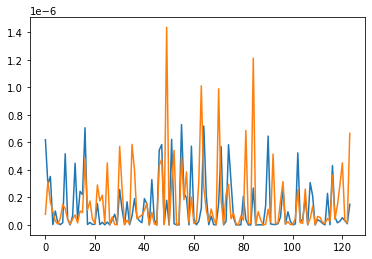

In [14]:
import matplotlib.pyplot as plt
plt.plot(score_LDA_test)


et on choisit la classe qui maximise le score (pour chaque élement des données de test):

In [15]:
# pred_LDA_test = ### TO DO #### 
# pred_LDA_test
# # VertebralClas_test  # pour comparaison

pred_LDA_test = [[0 if np.argmax(S)==1 else 1] for S in score_LDA_test]
print((pred_LDA_test))

[[1], [0], [1], [0], [1], [1], [0], [0], [1], [0], [0], [1], [1], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [1], [1], [0], [0], [0], [1], [0], [0], [1], [0], [1], [1], [1], [0], [1], [1], [1], [0], [0], [1], [0], [1], [0], [1], [1], [0], [0], [1], [1], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [1], [0], [0], [1], [1], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [1], [1], [1], [0], [0], [1], [1], [1], [0], [0], [1], [1], [0], [0], [0], [0], [0], [1], [0], [1], [1], [0], [0], [0], [0], [0], [0]]


La matrice de confusion est une matrice qui synthétise les performances d'une régle de classification. Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe estimée. La cellule (ligne L, colonne C) contient le nombre d'éléments de la classe réelle L qui ont été estimés comme appartenant à la classe C. Voir par exemple [ici](https://fr.wikipedia.org/wiki/Matrice_de_confusion).


> Evaluer les performances de la méthode sur l'échantillon test. Vous pourrez utiliser la fonction [`confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) de la librairie [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [16]:
print(vertebralClas_test)

['NO' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'NO' 'NO'
 'NO' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'NO' 'NO' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'NO' 'NO' 'AB' 'NO' 'AB' 'NO' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'NO'
 'NO' 'AB' 'AB' 'NO' 'NO' 'AB' 'AB' 'AB' 'NO' 'NO' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB'
 'AB' 'NO' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'NO' 'NO' 'AB' 'AB' 'AB'
 'NO' 'NO' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'NO' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB']


In [17]:
vraie_classe_test = 1 * (vertebralClas_test == "NO") 
cnf_matrix_LDA_test = confusion_matrix(vraie_classe_test,pred_LDA_test)
cnf_matrix_LDA_test.astype('float') / cnf_matrix_LDA_test.sum(axis=1).reshape(-1,1) 

array([[0.79120879, 0.20879121],
       [0.12121212, 0.87878788]])

Nos résultats stipulent que l'on a eu 79% de bonnes réponses pour la classe 0 et 87.9 % de bonnes réponses pour la classe 1. Ce sont de bons résultats pour une classification binaire.

> Vérifier que l'évaluation de la méthode sur les données d'apprentissage donne un résulat sensiblement plus optimiste.

In [18]:
score_LDA_train =  [[(n_NO/ntrain)*multivariate_normal.pdf(x,mean_NO,Intra_Cov),(n_AB/ntrain)*multivariate_normal.pdf(x,mean_AB,Intra_Cov)]  for x in vertebralVar_train]
pred_LDA_train = [[0 if np.argmax(S)==1 else 1] for S in score_LDA_train]
vraie_classe_train = 1 * (vertebralClas_train == "NO") 
cnf_matrix_LDA_train =  confusion_matrix(vraie_classe_train,pred_LDA_train)
cnf_matrix_LDA_train.astype('float') / cnf_matrix_LDA_train.sum(axis=1).reshape(-1,1) 

array([[0.84745763, 0.15254237],
       [0.1641791 , 0.8358209 ]])

En appliquant la méthode sur le train set, nous obtenons de meilleurs résultats de prédiction en moyenne. C'est normal car le principe des techniques de Machine Learning est de tester les modèles sur des données qu'il n'a jamais vu. En infiltrant des données de train pour tester le modèle, on introduit automatiquement un biais dans notre test qui améliore faussement nos résultats de prédictions. Le modèle doit être performant pour des données qu'il n'a jamais vu, c'est ce qui est demandé dans les utilisations réelles.

Il existe bien sûr une fonction scikit-learn pour la méthode LDA : voir [ici](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).

# Regression logistique

> Ajuster un modèle de régression logistique sur les données d'apprentissage en utilisant la fonction  `sklearn.linear_model.LogisticRegression`, voir [ici](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).   
> Par défaut une penalty $l_2$ est présente dans la fonction de perte (voir la doc). Pour obtenir un ajustement pour la regression logistique standard, il faut donc  prendre garder à préciser `penalty=‘none’` dans les options de la fonction.

In [19]:
logreg = LogisticRegression(penalty='none',random_state=0).fit(vertebralVar_train, vertebralClas_train)

> Afficher les coefficients estimés de la regression logistique 

In [20]:
logreg.coef_

array([[ 0.02644456, -0.11740681,  0.03053553,  0.04575155,  0.11721625,
        -0.16310303]])

> Afficher avec la fonction `predict_proba` les estimations des probabilités a posteriori sur l'échantillon de test.

In [21]:
probas = logreg.predict_proba(vertebralVar_test)
print(probas[:10])

[[7.41668000e-02 9.25833200e-01]
 [2.59628259e-01 7.40371741e-01]
 [3.30056549e-01 6.69943451e-01]
 [9.99989686e-01 1.03143639e-05]
 [1.82675746e-01 8.17324254e-01]
 [1.30787948e-01 8.69212052e-01]
 [9.97663882e-01 2.33611811e-03]
 [9.93476906e-01 6.52309377e-03]
 [6.08401344e-02 9.39159866e-01]
 [5.38251865e-01 4.61748135e-01]]


> Afficher la matrice de confusion et comparer avec les résultats avec ceux de la LDA

In [22]:
pred_logreg_test = [['NO' if np.argmax(S)==1 else 'AB'] for S in logreg.predict_proba(vertebralVar_test)]
cnf_matrix_logreg_test = confusion_matrix(vertebralClas_test,pred_logreg_test)
cnf_matrix_logreg_test.astype('float') / cnf_matrix_logreg_test.sum(axis=1).reshape(-1,1)

array([[0.81318681, 0.18681319],
       [0.06060606, 0.93939394]])

Nous obtenons une prédiction moyenne de 87.5%, résultat meilleur que pour la LDA dans ce cas (83.5%)

> **Bonus** (à faire à la fin si vous le souhaitez) : recoder par vous-même un prédicteur de régression logistique et comparer vos prévisions avec celles obtenues par la fonction de sklearn. Notez que sur ce jeu de données l'estimation du modèle de régression logistique est relativement instable du fait que la fonction de vraisembance correspondante est assez ``plate".

# Analyse Discriminante Quadratique (QDA)

> Reprendre et adapter les codes précédents (de la LDA) pour ajuster cette fois un classifieur par analyse discriminante quadratique sur les données d'apprentissage. 
> 
> Evaluer la qualité du classifieur sur les données de test.

In [23]:
score_QDA_test = [[(n_NO/ntrain)*multivariate_normal.pdf(x,mean_NO,Cov_NO ),(n_AB/ntrain)*multivariate_normal.pdf(x,mean_AB,Cov_AB)]  for x in vertebralVar_test]
pred_QDA_test =  [['AB' if np.argmax(S)==1 else 'NO'] for S in score_QDA_test]
cnf_matrix_QDA_test = confusion_matrix(vertebralClas_test,pred_QDA_test)
cnf_matrix_QDA_test.astype('float') / cnf_matrix_QDA_test.sum(axis=1).reshape(-1,1) 
#On obtient un taux de prédiction correct à 85%. C'est plus que la LDA et la régression.

array([[0.76923077, 0.23076923],
       [0.21212121, 0.78787879]])

Il existe bien sûr une fonction scikit-learn pour la méthode QDA : voir [ici](
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis).

# Gaussian Naive Bayes

Nous allons maintenant ajuster un classifieur naif bayesien sur les données d'apprentissage.

Pour une observation $x \in \mathbb R^6$, la régle du MAP consiste cette fois à choisir la catégorie $\hat y (x) = \hat k $ qui maximise (en $k$) 
$$ score_k(x) = \hat \pi_k \prod_{j=1} ^6  \hat f_{k,j}(x_j)   $$
où :
- $k$ est le numéro de la classe ;
- $\hat \pi_k$ est la proportion observée de la classe $k$, 
- $\hat f_{k,j} $ est la densité gaussienne univariée de la classe $k$ pour la variable $j$. Les paramètres de cette loi valent (ajustés par maximum de vraisemblance) :
    - $\hat \mu_{k,j}$ : la moyenne empirique de la variable $X^j$ restreinte à la classe k,
    - $ \hat \sigma^2_{k,j}$ : la variance empirique de la variable $X^j$ restreinte à la classe k.
    
Noter que la fonction $x \mapsto  \prod_{j=1} ^6  f_{k,j}(x_j) $ peut aussi être vue comme une densité gaussienne multidimensionnelle de moyenne $(\mu_{k,1}, \dots, \mu_{k,6})$ et de matrice de covariance diagonale $diag(\hat \sigma^2_{k,1},\dots,\hat  \sigma^2_{k,6})$. Cette remarque évite de devoir calculer le produit de 6 densités univariées, à la place on calcule plus directement la valeur de la densité multidimensionnelle.

Calcul des moyennes et des variances de chaque variable pour chacun des deux groupes :

Au vu de l'indépendance, en hypothèse, sur le modèle Naive Bayes des X sachant Y, calculer les matrices de cov de la sorte est une solution.

In [24]:
mean_AB = np.mean(vertebralVar_train_AB,axis=0)
mean_NO = np.mean(vertebralVar_train_NO,axis=0)

# variances estimées coord par coord pour AB (sur le train) :
var_AB = np.var(vertebralVar_train_AB,axis=0)
# variances estimées coord par coord pour NO (sur le train) :
var_NO = np.var(vertebralVar_train_NO,axis=0)

# on forme les matrices de covariance (matrices diagonales car indep) :
Cov_NB_AB =  np.diag(var_AB) 
Cov_NB_NO =  np.diag(var_NO)

Calcul du "score" sur chaque groupe pour chaque element des données test : 

In [25]:
score_NB_test = [[(n_NO/ntrain)*multivariate_normal.pdf(x,mean_NO,Cov_NB_NO),(n_AB/ntrain)*multivariate_normal.pdf(x,mean_AB,Cov_NB_AB)]  for x in vertebralVar_test]
pred_NB_test = [['AB' if np.argmax(S)==1 else 'NO'] for S in score_NB_test]

Affichage de la matrice de confusion sur les données de test :

In [26]:
cnf_matrix_NB_test = confusion_matrix(vertebralClas_test,pred_NB_test)
cnf_matrix_NB_test.astype('float') / cnf_matrix_NB_test.sum(axis=1).reshape(-1,1) 

array([[0.73626374, 0.26373626],
       [0.15151515, 0.84848485]])

>  Il existe bien sûr une fonction scikit-learn  pour la méthode Naive Bayes : voir [ici](http://scikit-learn.org/stable/modules/naive_bayes.html). Vérifier que votre prédicteur donne la même réponse de cette fonction.

In [27]:
gnb = GaussianNB()
gnb.fit(vertebralVar_train, vertebralClas_train)
gnb.predict(vertebralVar_test)
cnf_matrix_gnb_test = confusion_matrix(vertebralClas_test,gnb.predict(vertebralVar_test))
cnf_matrix_gnb_test.astype('float') / cnf_matrix_gnb_test.sum(axis=1).reshape(-1,1) 

array([[0.73626374, 0.26373626],
       [0.15151515, 0.84848485]])

Les deux méthodes, celle codée à la main et celle de scikit coïncident bien d'un point de vue prédictions. Les deux manières de faire donnent une moyenne de prédiction de 79%.

# Classifieur par plus proches voisins

Il est préférable d'utiliser la structure de données de type [k-d tree](https://en.wikipedia.org/wiki/K-d_tree) pour effectuer des requêtes de plus proches voisins dans un nuage de points. 

> Contruction du k-d tree pour les données train (pour la métrique euclidienne) :

In [28]:
tree = KDTree(vertebralVar_train)

> Rechercher les 10 plus proches voisins dans les données d'apprentissage du premier point des données de test et afficher les classes de ces observations voisines.

In [29]:
indices_voisins =  tree.query(vertebralVar_test[:1],k=10)
print(indices_voisins[1])
classes_voisins = vertebralClas_train[indices_voisins[1]]
print(classes_voisins)  

[[ 39   1 169 170  57  86 133  87  84  79]]
[['NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'AB' 'NO' 'NO']]


Nous aurons plus tendance à utiliser un chiffre impair de voisins pour ne jamais créer du biais sur l'égalité des voisins en faisant un >= ou un choix random.

Pour le classifieur par plus proches vosins, la prediction est la classe majoritaire des k plus proches voisins.

> Donner la prédiction pour le premier point de test par vote majoritaire sur ses 10 plus proches voisins 

In [30]:
def predict_kprochevois(x):
    
    k=0
    
    for clas in x:
        
        k = k + int(clas=='AB')
        
    return('AB' if k>=5 else 'NO')

> Donner la prediction du classifieur ppv pour toutes les données de test. Evaluer la qualité du classifieur.

In [31]:
k_class = 10  #nombre de plus proche voisins utilisés
plus_proches_voisins=vertebralClas_train[tree.query(vertebralVar_test,k=k_class)[1]]
pred_kprochevois_test = []
for L in plus_proches_voisins:
    pred_kprochevois_test.append(predict_kprochevois(L))
print(pred_kprochevois_test)
cnf_matrix_kNN =confusion_matrix(vertebralClas_test,pred_kprochevois_test)
cnf_matrix_kNN.astype('float') / cnf_matrix_kNN.sum(axis=1).reshape(-1,1) 
#La méthode des plus proches voisins donne un taux de prédiction de 80%.

#La méthode la plus précise (mais c'est également la plus coûteuse) est la QDA. Les autres méthodes donnent des performances globalement simlilaires.

['NO', 'NO', 'NO', 'AB', 'AB', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'AB', 'NO', 'NO', 'NO', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'NO', 'NO', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'NO', 'AB', 'NO', 'NO', 'NO', 'AB', 'NO', 'NO', 'NO', 'AB', 'AB', 'NO', 'AB', 'NO', 'AB', 'NO', 'NO', 'AB', 'AB', 'NO', 'NO', 'AB', 'AB', 'AB', 'NO', 'NO', 'AB', 'AB', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'NO', 'NO', 'NO', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB', 'NO', 'NO', 'AB', 'AB', 'AB', 'AB', 'AB', 'NO', 'AB', 'NO', 'NO', 'AB', 'AB', 'NO', 'AB', 'NO', 'NO', 'AB', 'NO', 'NO', 'AB', 'AB', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'NO', 'AB', 'AB', 'AB', 'AB', 'AB', 'AB']


array([[0.83516484, 0.16483516],
       [0.15151515, 0.84848485]])

Il existe bien sûr une fonction scikit-learn pour le classifieur plus proche voisin, voir [ici](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).